# Init

## Imports

In [27]:
from vpython import *
import numpy as np
import pandas as pd

## Set Up

In [43]:
# Definition of parameters
rM0 = 4.6    # in units of R0
vM0 = 0.51   # in units of R0/T0
aM  = 1.01   # in units of R0/T0**2
TM  = 88.    # in units of T0
rS  = 3.e-7  # in units of R0

# Initialize distance and velocity vectors
vec_rM0 = vector(0, rM0, 0)
vec_vM0 = vector(vM0, 0, 0)

# Definition of the time step
dt0    = 2. * vM0 / aM
alpha0 = 0. 

# Define the function
def evolve_mercury(vec_rM_old, vec_vM_old, dt=dt0, alpha=alpha0):
    # Compute the strength of the acceleration      
    aMS = aM * ( 1. + alpha * rS / vec_rM_old.mag  ) / vec_rM_old.mag**2
    # Multiply by the direction
    vec_aMS = - aMS * ( vec_rM_old / vec_rM_old.mag )
    # Update velocity vector
    vec_vM_new = vec_vM_old + vec_aMS * dt
    # Update position vector
    vec_rM_new = vec_rM_old + vec_vM_new * dt
    return vec_rM_new, vec_vM_new

# define function for angle extraction
def angle_between(v1, v2):
    return acos( dot(v1, v2) / (v1.mag * v2.mag) ) * 180. / pi

def get_delta_Theta(alpha, dt):
    # Run parameters
    vec_r_last = vec_rM0
    turns      = 0
    max_turns  = 10
    list_perih = list()
    list_angle = list()
    sum_angle  = 0.
    
    # define the initial coordinates; M = mercury, S = sun
    Mpos = vec_rM0
    Mvel = vec_vM0

    # find perihelion for each turn an print it out
    while turns < max_turns:
        vec_r_before_last = vec_r_last
        vec_r_last        = vector(Mpos)
        # update the velocity and position
        Mpos , Mvel = evolve_mercury(Mpos , Mvel , dt=dt,alpha=alpha)
        # check if at perihelion
        if vec_r_before_last.mag > vec_r_last.mag < Mpos.mag:
            turns = turns+1
            list_perih.append(vec_r_last)
            if turns > 1:
                # draw location of perihelion
                sphere(color=color.green, radius=0.2, pos=vec_r_last)
                # display intermediate results
                list_angle.append(angle_between(list_perih[-2],list_perih[-1]))
                #print("turn: n={n}, perihilion growth: delta Theta={angle}".format(
                #    n=turns, angle=list_angle[-1]
                #))
                # note that list_perih[-2] acces the second last and
                #  list_perih[-1] the last element in the list
    avg_angle=np.sum(list_angle)/len(list_angle)

    # display the average
    #print("--------------------------------")
    #print("average perihilion growth: delta Theta={avg}".format(avg=avg_angle))
    return np.array(list_angle)

# Farming

In [44]:
angles=get_delta_Theta(0, dt0)
print np.average(angles), np.std(angles)

3.33787341391 0.719554219021


In [46]:
dt_steps = [dt0/n for n in [1,2,5,10,20,50,100]]
alphas   = np.linspace(1.e5, 1.e6, 10)

data = list()

for dt in dt_steps:
    for alpha in alphas:
        
        angles = get_delta_Theta(alpha, dt)
        
        data.append({
            "dt": dt,
            "alpha": alpha,
            "avg": np.average(angles), 
            "std": np.std(angles),
            "angles": angles,
        })
        

df = pd.DataFrame(data)
df.head()

,alpha,angles,avg,dt,std
0,100000.0,"[3.06014945396, 3.45912357982, 3.06018635931, ...",3.237438,1.009901,0.198251
1,200000.0,"[2.2585123159, 4.26534377924, 2.25833404896, 4...",3.373339,1.009901,0.997210
2,300000.0,"[1.57306233631, 4.95511931085, 4.95548942329, ...",3.452167,1.009901,1.680603
3,400000.0,"[5.53255457761, 1.00149889196, 5.53252001625, ...",4.022190,1.009901,2.135952
4,500000.0,"[5.99969454419, 5.9995394759, 0.54009598321, 5...",4.786368,1.009901,2.269728


# Plotting

In [111]:
import seaborn as sns
import matplotlib
import matplotlib.pylab as plt
import re

font="Times New Roman"
sns.set(
    style="ticks", 
    font_scale=1.,
    font=font,
)
matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams['mathtext.rm'] = 'Times New Roman'
matplotlib.rcParams['mathtext.it'] = 'Times New Roman:italic'
matplotlib.rcParams['mathtext.bf'] = 'Times New Roman:bold'

cm2inch = lambda cm: cm/2.54

a4w = cm2inch(210./10) #mm
a4h = cm2inch(297./10) #mm

## Linear Interpolation

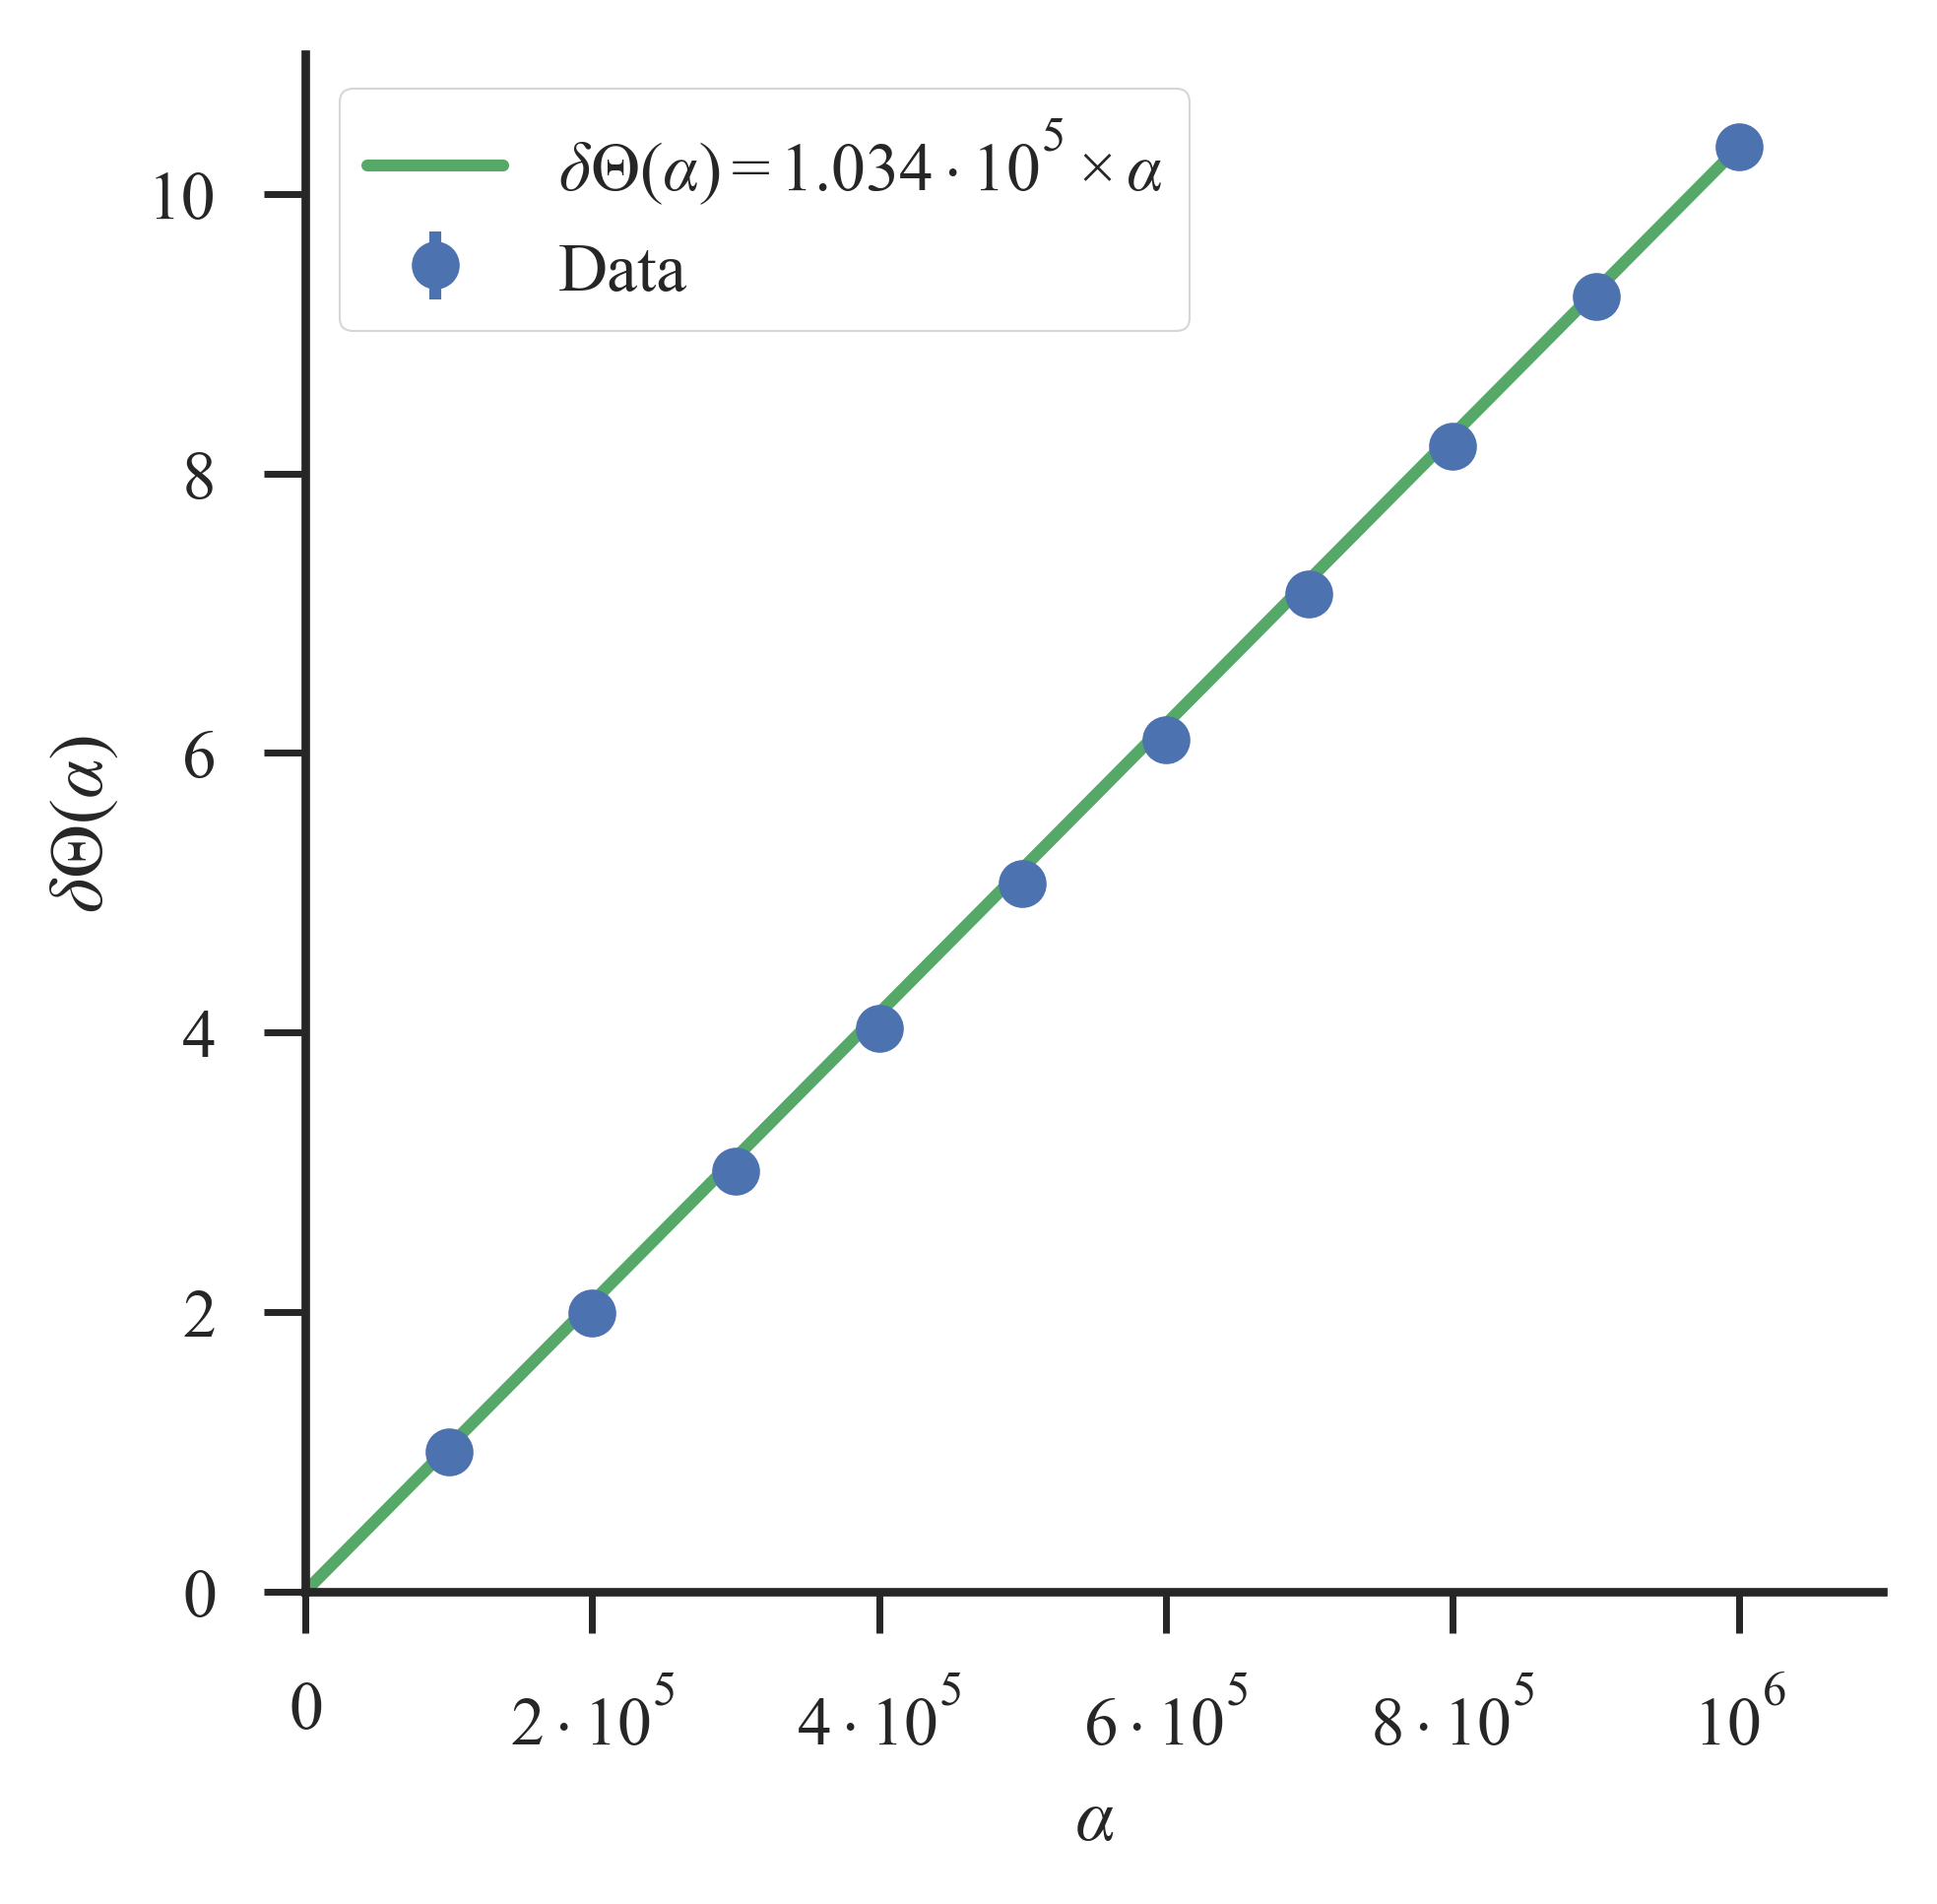

In [171]:
fig = plt.figure(figsize=(a4w*0.5, a4w*0.5), dpi=500)

tf = df.query("dt < 0.02")
m  = tf.query("alpha==1.e6")["avg"].as_matrix()[0]/1.e6
alpha_lin = np.linspace(0,1.e6,400)
theta_lin = m*alpha_lin

ax = fig.gca()

fit_label=r"$\delta \Theta(\alpha) = {m:1.3e} \times \alpha$".format(m=m)
fit_label=re.sub("([0-9\.]+)e-0([1-9]+)","\g<1> \cdot 10^{\g<2>}",fit_label)

ax.errorbar(tf.alpha, tf["avg"], tf["std"], marker="o", linestyle="None", label="Data")
ax.plot(alpha_lin, theta_lin, label=fit_label)

ax.plot()

sns.despine()

ax.set_xlim(0, 1.1e6)
ax.set_ylim(0,11)

ax.set_ylabel(r"$\delta \Theta(\alpha)$")
ax.set_xlabel(r"$\alpha$")

ax.set_xticklabels(["$0$"]+["${n}\cdot10^{{5}}$".format(n=n) for n in range(2,10,2)]+["$10^{6}$"])

ax.legend(loc="best", frameon=True)

plt.show(fig)

In [119]:
fig.savefig("alpha-angle.pdf", bbox_inches="tight")

# Timestep errors

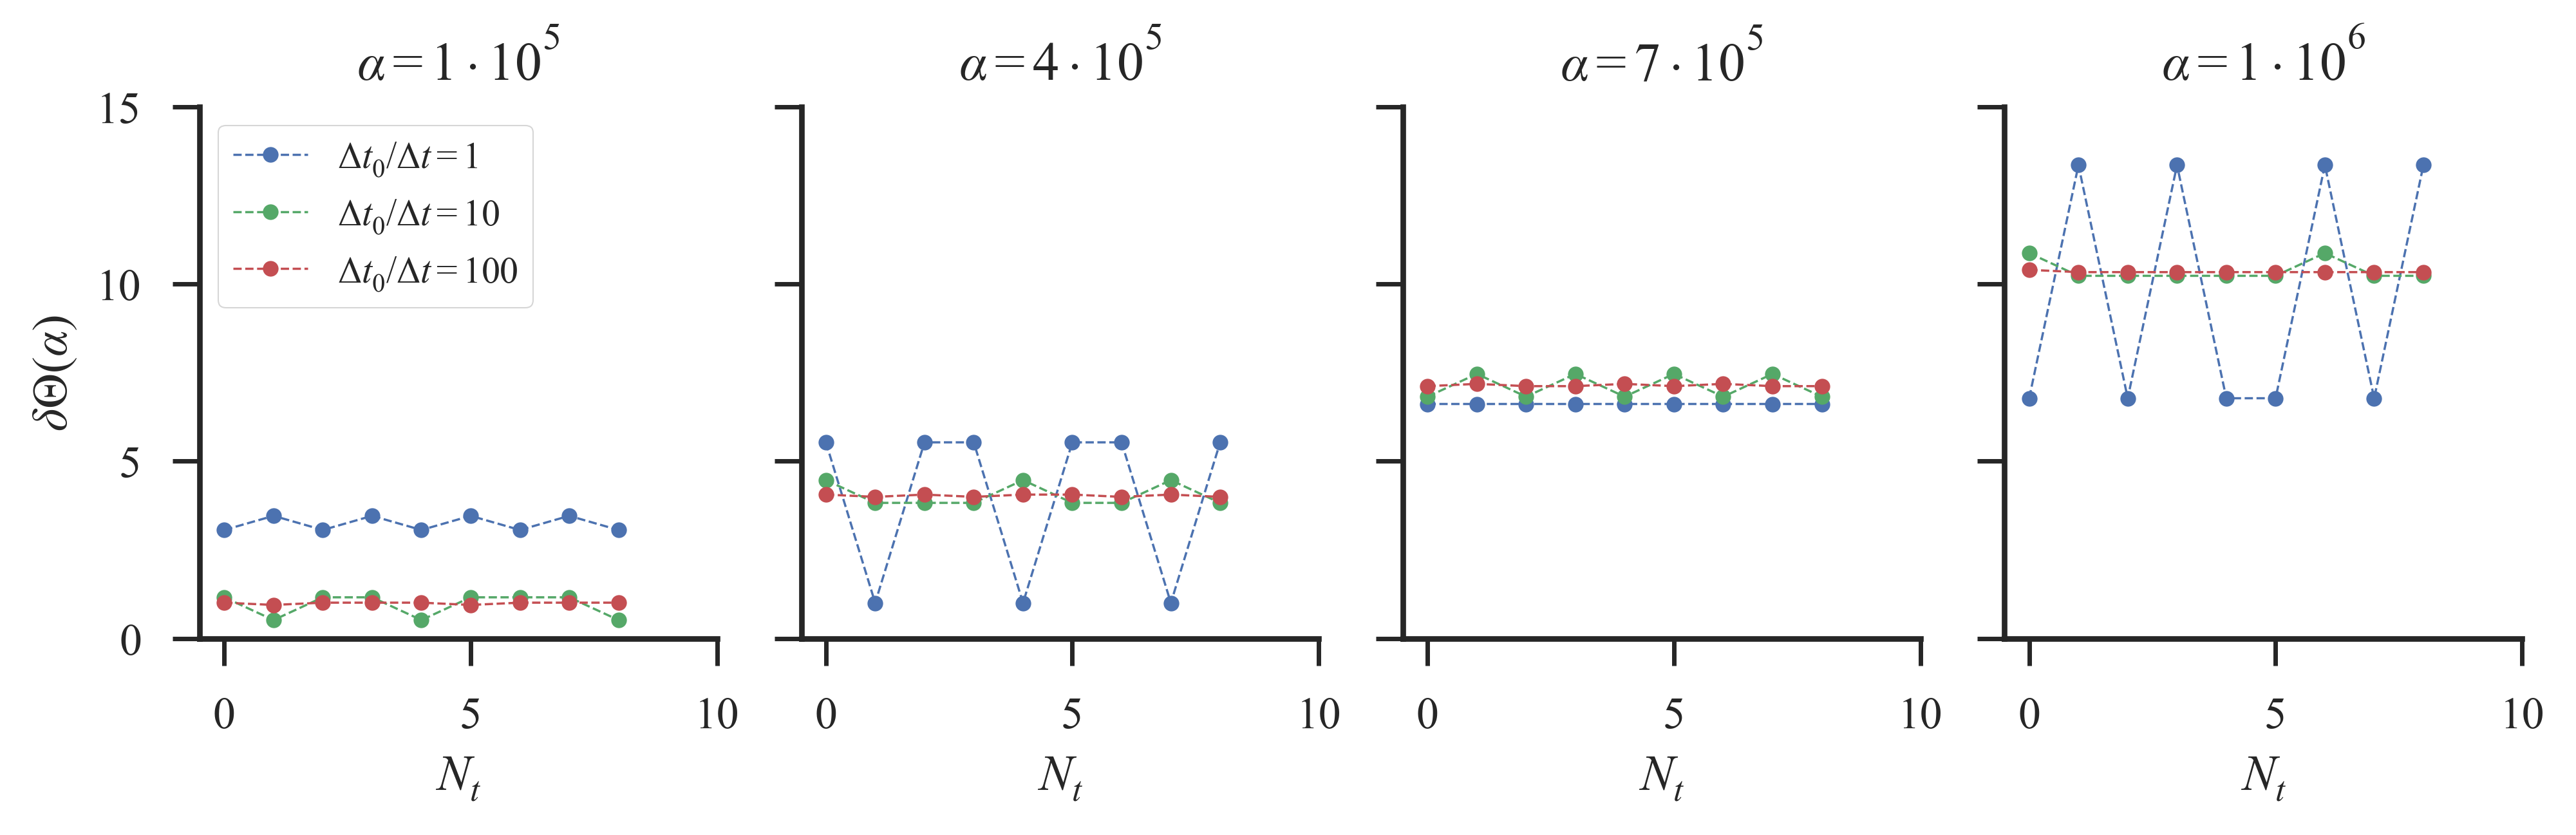

In [239]:
fig, axs = plt.subplots(figsize=(a4w, a4w/3), dpi=500, ncols=4, nrows=1, sharex=True, sharey=True)

ax = fig.gca()


for alpha, ax in zip(df["alpha"].unique()[::3], axs):
    ax.set_xlabel(r"$N_t$")
    for dt in df["dt"].unique()[[0,3,-1]]:
        tf = df.query("dt == @dt and alpha == @alpha")
        ind = tf.index[0]
        ax.plot(tf.loc[ind,"angles"], marker=".", linestyle="--", lw=0.5,label="$\Delta t_0/\Delta t ={0:d}$".format(int(dt0/dt)))
        title=r"$\alpha = {0:1.0e}$".format(alpha)
        ax.set_title(re.sub("([0-9]+)e\+0([1-9]+)","\g<1> \cdot 10^{\g<2>}",title))
        #ax.fill_between(
        #    range(-1,12),
        #    tf.loc[ind, "avg"]-tf.loc[ind, "std"], 
        #    tf.loc[ind, "avg"]+tf.loc[ind, "std"],
        #    alpha=0.5,
        #    zorder=-100+int(dt0/dt)
        #)


sns.despine()

ax.set_xlim(-0.5, 10)
ax.set_ylim(0,15)

axs[0].set_ylabel(r"$\delta \Theta(\alpha)$")
for n in range(1,4):
    plt.setp(axs[n].get_yticklabels(),visible=False)

axs[0].legend(loc="upper left", frameon=True, fontsize="x-small")

plt.tight_layout()

plt.show(fig)

In [240]:
fig.savefig("angular-variaton.pdf", bbox_inches="tight")